In [1]:
#import libraries
import pandas as pd;
import geopandas as gpd;
import matplotlib.pyplot as plt;
%matplotlib notebook
import numpy as np; #Using numpy for regex
import pgeocode; #Used to convert postcodes to locations
from shapely.geometry import Point; # Shapely for converting latitude/longtitude to geometry
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

import geopy.distance
from geopy.geocoders import Nominatim
import json;



import traveltimepy as ttpy
import os
from datetime import datetime #for examples
#TODO: store credentials in an environment variable
os.environ["TRAVELTIME_ID"] = '466b4c75'
os.environ["TRAVELTIME_KEY"] = 'aa473fed8d8638f1b576305a7e1fc019'

pd.set_option('display.precision', 1)

In [2]:
#Load FL Data
df = pd.read_excel(r'volumes.xlsx', sheet_name='Raw Imports', header=0)
df['PC_Area'] = df['CDPostCode'].str.extract(r'(^[a-zA-Z][a-zA-Z]?)')
df['PC_District'] = df['CDPostCode'].str.extract(r'([^\s]+)')

In [12]:
#Set up Freightliner locations
data = [['Leeds', 53.7496, -1.5494], ['Doncaster', 53.497, -1.1821]]
  
# Create the pandas DataFrame
fl_locations = pd.DataFrame(data, columns=['Terminal', 'Lat', 'Long'])  

# print dataframe.
fl_locations

# creating a geometry column 
geometry = [Point(xy) for xy in zip(fl_locations['Long'], fl_locations['Lat'])]
# Coordinate reference system : WGS84
#crs = {'init': 'epsg:4326'}
crs = 'epsg:4326'
# Creating a Geographic data frame 
fl_points = gpd.GeoDataFrame(fl_locations, crs=crs, geometry=geometry)

indexed_fl_points = fl_points.set_index('Terminal')
fl_points

,Terminal,Lat,Long,geometry
0,Leeds,53.7,-1.5,POINT (-1.54940 53.74960)
1,Doncaster,53.5,-1.2,POINT (-1.18210 53.49700)


In [4]:
explore = df.groupby(["JobType", "Load"])["Unload"].count().reset_index()
explore

,JobType,Load,Unload
0,Import,COATBRIDGE,3
1,Import,DONCASTER,429
2,Import,FELIXSTOWE,2
3,Import,HULL,289
4,Import,IMMINGHAM,4
5,Import,LEEDS,8150
6,Import,LIVERPOOL,2
7,Import,MIDDLESBROUGH,3
8,Import,SEAFORTH,2
9,Import,SHEFFIELD,136


In [5]:
#Inclusion & Exclusion Criteria
#TODO: Separate maps for Leeds and Doncaster

load_included = ['LEEDS']
Postcode_excluded = ['TESC', 'TS6 6UD']
slice = df[(df.Load.str.contains('|'.join(load_included))) & ~(df.CDPostCode.str.contains('|'.join(Postcode_excluded)))]
slice

,JobType,Load,ColDel,CDPostCode,LetterLetter Number Number,Unload,PC_Area,PC_District
3,Import,LEEDS,CASTLEFORD,B26 3QD,B26,LEEDS,B,B26
4,Import,LEEDS,CASTLEFORD,B26 3QD,B26,LEEDS,B,B26
5,Import,LEEDS,CASTLEFORD,B26 3QD,B26,LEEDS,B,B26
6,Import,LEEDS,CASTLEFORD,B26 3QD,B26,LEEDS,B,B26
7,Import,LEEDS,CASTLEFORD,B26 3QD,B26,LEEDS,B,B26
...,...,...,...,...,...,...,...,...
13033,Import,LEEDS,SELBY,YO8 8BL,YO8,LEEDS,YO,YO8
13034,Import,LEEDS,SELBY,YO8 8BL,YO8,LEEDS,YO,YO8
13035,Import,LEEDS,SELBY,YO8 8BL,YO8,LEEDS,YO,YO8
13036,Import,LEEDS,SELBY,YO8 8BL,YO8,LEEDS,YO,YO8


# Postcode District Level Analysis (e.g., LN10)

<IPython.core.display.Javascript object>


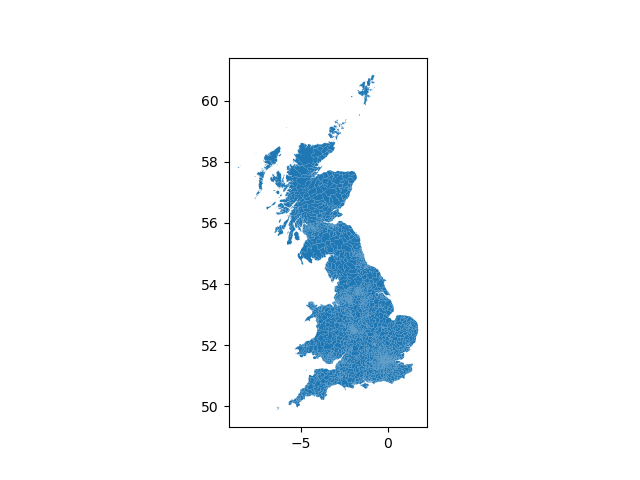

In [6]:
#Load and check map of PostCode Districts
fp = "postcodes/Districts.shp"
map_df = gpd.read_file(fp)
map_df.plot()

In [7]:
#Examine Header data of map
map_df.head()

,name,geometry
0,AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663..."
1,AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57..."
2,AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57..."
3,AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525..."
4,AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619..."


In [20]:
#Aggregate postcodes with total containers for the year
aggregate_district = slice.groupby(["PC_District"])['Unload'].count().reset_index()
sorted_area = aggregate_district.sort_values(by = "Unload", ascending = 0).head(20)
#sorted_area['Unit_pct'] = sorted_area.Unload / df.Unload.sum()
#sorted_area.style.format({
#    'Unit_pct': '{:,.1%}'.format,
#})
aggregate_district['PC_District'] = aggregate_district['PC_District'].str.upper() 
aggregate_district

,PC_District,Unload
0,B26,7
1,B78,464
2,B98,1
3,BB1,7
4,BB10,4
...,...,...
218,YO62,1
219,YO7,6
220,YO8,37
221,DN14,1


In [9]:
reset_index = map_df.set_index("name")
merged = reset_index.join(aggregate_district.set_index("PC_District"))
merged["Unload"] = merged["Unload"].fillna(0)
merged

,geometry,Unload
name,,
AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663...",0.0
AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57...",0.0
AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57...",0.0
AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525...",0.0
AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619...",0.0
...,...,...
YO90,"MULTIPOLYGON (((-1.08958 53.95931, -1.08891 53...",0.0
YO91,"POLYGON ((-1.06530 53.97796, -1.06634 53.97830...",0.0
ZE1,"MULTIPOLYGON (((-1.17282 60.12108, -1.18797 60...",0.0


<IPython.core.display.Javascript object>


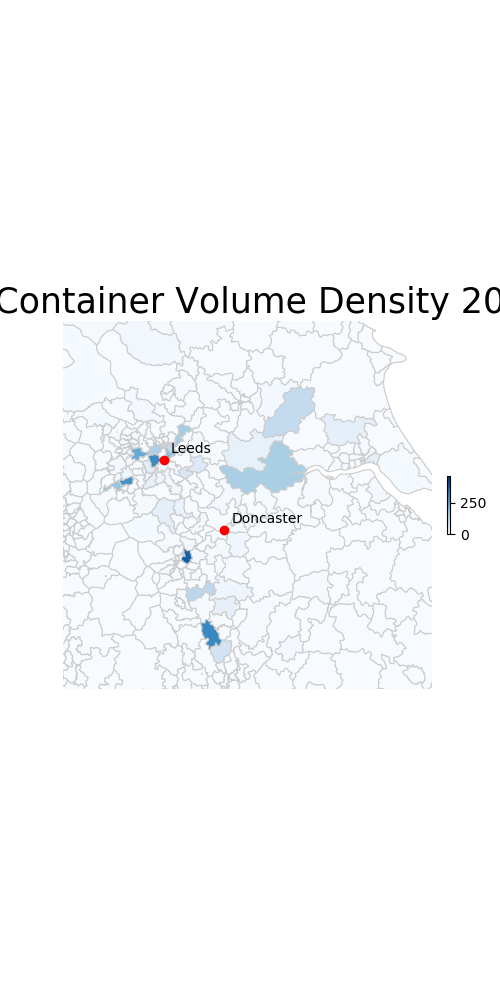

In [31]:
variable = "Unload"
vmin, vmax = 0, 464
fig, ax = plt.subplots(1, figsize=(5, 10))

# add a title and remove axis
ax.set_title("FL Container Volume Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)


ax.annotate("Leeds", (indexed_fl_points.loc["Leeds"]["Long"], indexed_fl_points.loc["Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax.annotate("Doncaster", (indexed_fl_points.loc["Doncaster"]["Long"], indexed_fl_points.loc["Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")


merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
fl_points.plot(ax=ax, color="red")



In [14]:
travel_time = 59*60
time = "2022-10-12T09:00:00Z"

travel_time_data = []

for x in fl_points['Terminal']:
    search = {
      'id': x,
      'departure_time':  time,
      'travel_time': travel_time,
      'coords': {'lat': fl_points[fl_points['Terminal'].str.contains(x)]["Lat"].iloc[0], 'lng': fl_points[fl_points['Terminal'].str.contains(x)]["Long"].iloc[0]},
      'transportation': {'type': "driving"},
      'properties': ["travel_time_all"],
      "reachable_postcodes_threshold": 0.1
    }
    data = ttpy.time_filter_postcode_districts(departure_searches=search)
    travel_time_data.append(data)
    
travel_time_data

[{'results': [{'search_id': 'Leeds',
    'districts': [{'code': 'ls10',
      'properties': {'travel_time_all': {'min': 70,
        'max': 1038,
        'mean': 462,
        'median': 392}}},
     {'code': 'dn8',
      'properties': {'travel_time_all': {'min': 2439,
        'max': 2973,
        'mean': 2647,
        'median': 2657}}},
     {'code': 'yo8',
      'properties': {'travel_time_all': {'min': 2017,
        'max': 3507,
        'mean': 2661,
        'median': 2651}}},
     {'code': 'hx6',
      'properties': {'travel_time_all': {'min': 2197,
        'max': 2806,
        'mean': 2468,
        'median': 2442}}},
     {'code': 'm7',
      'properties': {'travel_time_all': {'min': 3001,
        'max': 3693,
        'mean': 3298,
        'median': 3291}}},
     {'code': 's66',
      'properties': {'travel_time_all': {'min': 2781,
        'max': 3451,
        'mean': 3140,
        'median': 3158}}},
     {'code': 'bl3',
      'properties': {'travel_time_all': {'min': 3230,
        '

In [21]:
df2 = aggregate_district

for search in travel_time_data:
    pcarea_tt = []
    mean_tt = []
    for pcarea in search.get('results')[0].get('districts'):
        pcarea_tt.append(pcarea.get('code').upper())
        mean_tt.append(pcarea.get('properties').get('travel_time_all').get('mean'))
    output_tt = pd.DataFrame(list(zip(pcarea_tt, mean_tt)),
               columns =['pc_area', 'mean_tt'])
    df2 = df2.merge(output_tt, left_on='PC_District', right_on='pc_area', how='left')
    df2['mean_tt'].fillna(100000, inplace=True)
    df2[search.get('results')[0].get('search_id')] = df2['mean_tt']
    df2.drop(columns=['pc_area', 'mean_tt'], inplace=True)
df2

,PC_District,Unload,Leeds,Doncaster
0,B26,7,100000.0,100000.0
1,B78,464,100000.0,100000.0
2,B98,1,100000.0,100000.0
3,BB1,7,100000.0,100000.0
4,BB10,4,100000.0,100000.0
...,...,...,...,...
218,YO62,1,100000.0,100000.0
219,YO7,6,3530.0,3921.0
220,YO8,37,2661.0,2368.0
221,DN14,1,2605.0,1942.0


In [ ]:
df1=data
bins = [0,40,50,60,70,100]
group_names=['F','S','C','B','A']
df1['grade']=pd.cut(data['student_mark'],bins,labels=group_names)
df1

In [26]:
df3 = df2
bins = [0, 15*60, 30 * 60, 45*60, 60*60, 100000]
group_names = ['< 15m', '15-30m', '30-45m', '45-60m', '60m+']
df3['Leeds band'] = pd.cut(df2['Leeds'], bins, labels=group_names)
df3['Doncaster band'] = pd.cut(df2['Doncaster'], bins, labels=group_names)
df3.groupby(on)

,PC_District,Unload,Leeds,Doncaster,Leeds band,Doncaster band
0,B26,7,100000.0,100000.0,60m+,60m+
1,B78,464,100000.0,100000.0,60m+,60m+
2,B98,1,100000.0,100000.0,60m+,60m+
3,BB1,7,100000.0,100000.0,60m+,60m+
4,BB10,4,100000.0,100000.0,60m+,60m+
...,...,...,...,...,...,...
218,YO62,1,100000.0,100000.0,60m+,60m+
219,YO7,6,3530.0,3921.0,45-60m,60m+
220,YO8,37,2661.0,2368.0,30-45m,30-45m
221,DN14,1,2605.0,1942.0,30-45m,30-45m


In [27]:
df3.to_csv('travel_time_FRS.csv')

# Postcode Area-level analysis (e.g., LN)

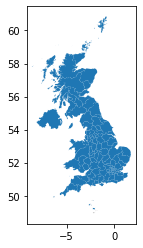

In [55]:
#Load and check map of PostCode Districts
fp_areas = "postcodes/Areas.shp"
map_df_areas = gpd.read_file(fp_areas)
map_df_areas.plot()

In [56]:
# Create Column with Postcode Area (one or two letters)
area_df = slice

In [57]:
#Aggregate postcodes with total containers for the year
aggregate_area = area_df.groupby(["PC_Area"])["Unload"].count().reset_index()
aggregate_area

,PC_Area,Unload
0,B,472
1,BB,20
2,BD,361
3,BL,2
4,CA,6
5,CH,3
6,CV,5
7,DE,1
8,DH,278
9,DL,133


In [58]:
reset_index = map_df_areas.set_index("name")
merged_area = reset_index.join(aggregate_area.set_index("PC_Area"))
merged_area["Unload"] = merged_area["Unload"].fillna(0)
merged_area

,geometry,Unload
name,,
AB,"POLYGON ((-2.21091 56.88580, -2.21858 56.88676...",0.0
AL,"POLYGON ((-0.37138 51.68730, -0.37227 51.68781...",0.0
B,"POLYGON ((-2.05436 52.24756, -2.05530 52.25006...",472.0
BA,"POLYGON ((-2.08430 51.31717, -2.08008 51.31421...",0.0
BB,"POLYGON ((-2.21557 53.73160, -2.21541 53.73145...",20.0
...,...,...
ZE,"MULTIPOLYGON (((-0.80210 60.40932, -0.80233 60...",0.0
BT,"MULTIPOLYGON (((-5.54258 54.29000, -5.54922 54...",0.0
GY,"MULTIPOLYGON (((-2.36625 49.40170, -2.36750 49...",0.0


In [59]:
nomi = pgeocode.Nominatim('GB')
nomi.query_postal_code("S9 1")

postal_code                                S9
country_code                               GB
place_name        Tinsley, Darnall, Wincobank
state_name                            England
state_code                                ENG
county_name                   South Yorkshire
county_code                           2637273
community_name                            NaN
community_code                            NaN
latitude                              53.4099
longitude                            -1.40847
accuracy                                    4
Name: 0, dtype: object

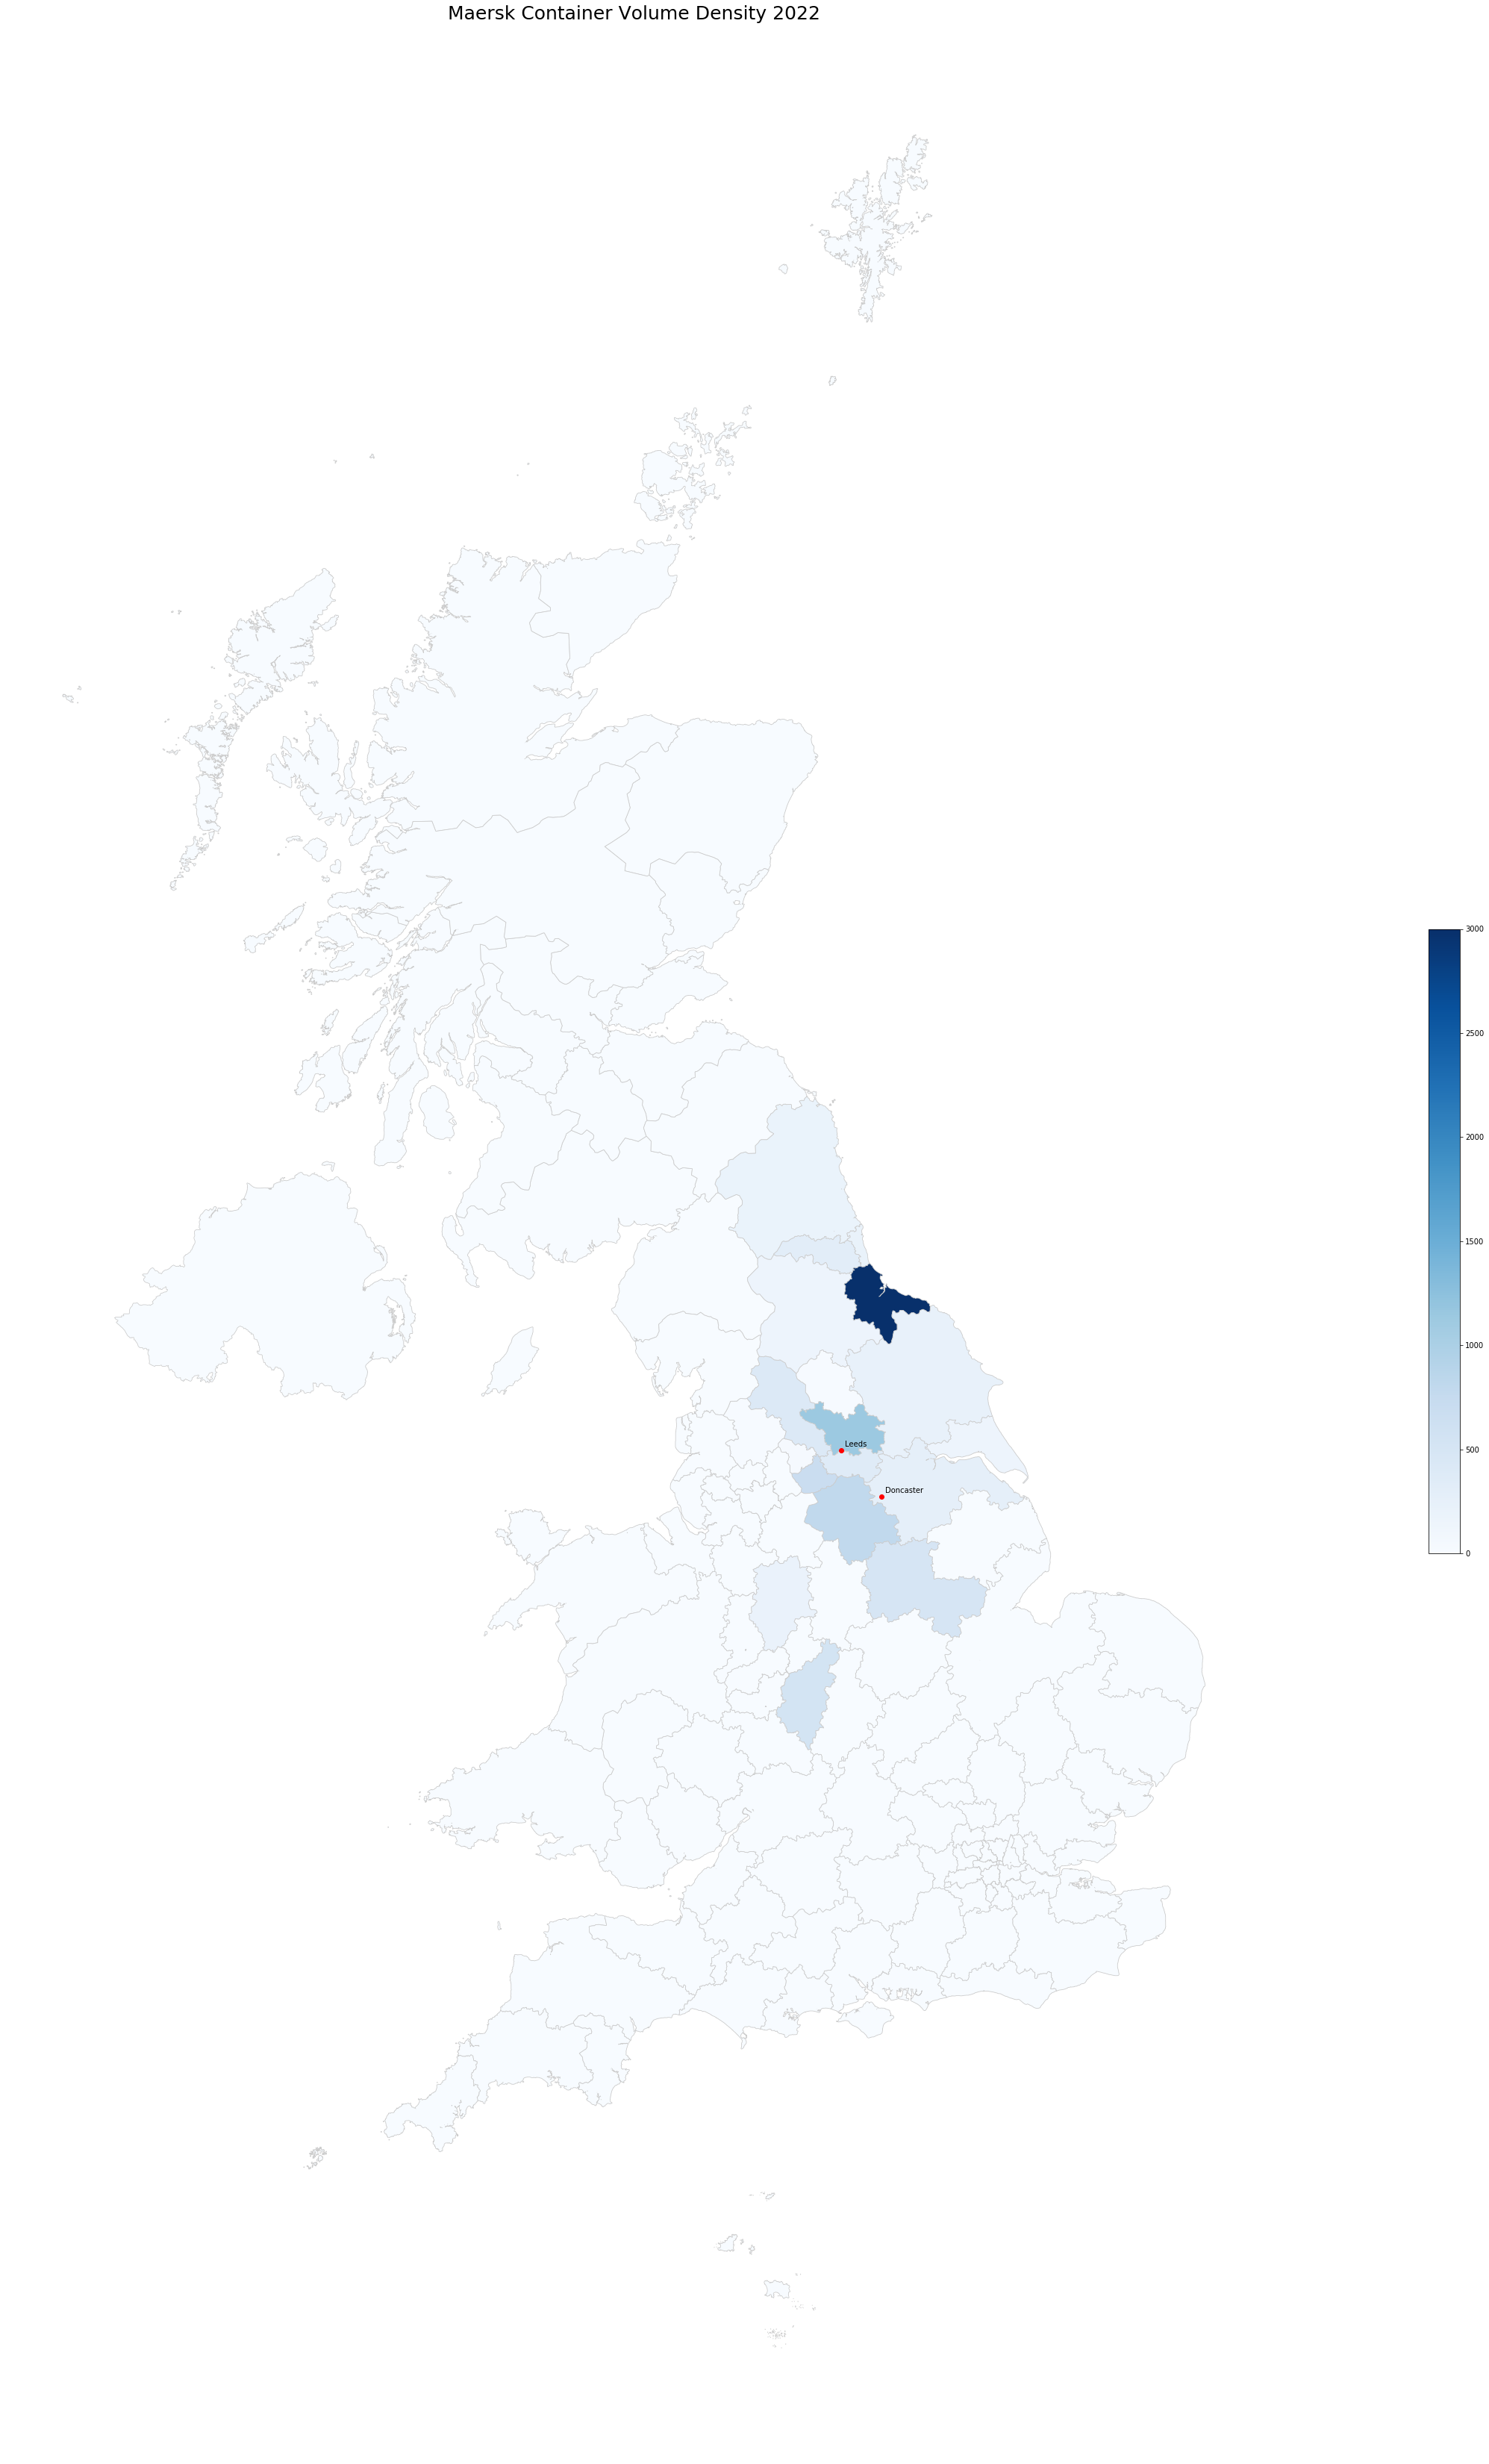

In [60]:
fig_com, ax_com = plt.subplots(1, figsize=(100, 60))
ax_com.axis('off')

vmin_area, vmax_area = 0, 3000
# add a title
ax_com.set_title("Maersk Container Volume Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin_area, vmax=vmax_area))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig_com.colorbar(sm, fraction=0.0075, pad=0.04)

ax_com.annotate("Leeds", (indexed_fl_points.loc["Leeds"]["Long"], indexed_fl_points.loc["Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax_com.annotate("Doncaster", (indexed_fl_points.loc["Doncaster"]["Long"], indexed_fl_points.loc["Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")

merged_area.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax_com, edgecolor='0.8') 
fl_points.plot(ax=ax_com, color="red")